In [72]:
from py2neo import Graph,Node,Relationship
import pandas as pd

In [73]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "omana1010"))

In [74]:
query = """
MATCH (i:InquirySource)
RETURN i.name AS InquirySource
"""
data = graph.run(query)
for d in data:
    print(d)

<Record InquirySource='REFERRAL'>
<Record InquirySource='JOINT PAST'>
<Record InquirySource='UNKNOWN'>
<Record InquirySource='EVENT'>
<Record InquirySource='ONLINE FORM'>
<Record InquirySource='DIRECT MAIL'>
<Record InquirySource='MEDIA'>
<Record InquirySource='OTHER'>


In [75]:
query = """
MATCH (i:InquirySource)
RETURN i.name AS InquirySource
ORDER BY InquirySource;
"""
data = graph.run(query).to_data_frame()
data

,InquirySource
0,DIRECT MAIL
1,EVENT
2,JOINT PAST
3,MEDIA
4,ONLINE FORM
5,OTHER
6,REFERRAL
7,UNKNOWN


In [76]:
query = """
MATCH (ss:SaleStatus)
WHERE ss.name = $name
MATCH (sid:Sale)-[:have_outcome]->(ss)
MATCH (i:InquirySource)-[:received_request]->(sid)
RETURN i.name AS source, ss.name AS total_won, COUNT(*) AS count
ORDER BY count DESC;
"""

data = graph.run(query, name="WON").to_data_frame()
data

,source,total_won,count
0,JOINT PAST,WON,208
1,REFERRAL,WON,13
2,EVENT,WON,2
3,UNKNOWN,WON,2
4,MEDIA,WON,1
5,OTHER,WON,1


In [77]:
type(data)

pandas.core.frame.DataFrame

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

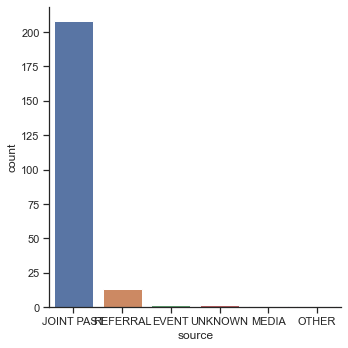

In [79]:
sns.catplot(x="source", y="count", kind="bar", data=data);

In [80]:
graph.run("MATCH (i:InquirySource) RETURN i.name AS InquirySource").to_table()

InquirySource
REFERRAL
JOINT PAST
UNKNOWN
EVENT
ONLINE FORM
DIRECT MAIL
MEDIA
OTHER


In [81]:
graph.evaluate("MATCH (i:InquirySource) RETURN count(i)")

8

### Cypher MATCH statement and returns Node objects:

In [82]:
from py2neo.ogm import GraphObject, Property

In [83]:
# Class method -1

In [84]:
class Sale(GraphObject):
    name = Property()
    CrossSale = Property()

In [85]:
[(a.name, a.CrossSale) for a in Sale.match(graph).limit(3)]

[('id-1001', 'No'), ('id-1002', 'No'), ('id-1003', 'Yes')]

In [86]:
# method -2

In [87]:
[(a["name"], a["CrossSale"])
     for a in graph.nodes.match("Sale").limit(3)]

[('id-1001', 'No'), ('id-1002', 'No'), ('id-1003', 'Yes')]

In [88]:
query = """
MATCH (c:Sale) RETURN count(c)
"""
data = graph.run(query).to_data_frame()
data

,count(c)
0,448


In [89]:
query = """
MATCH (c:Seller)-[:incharge_of]->()
WITH c, count(*) AS No_of_sales_attempt
RETURN c.name as name, No_of_sales_attempt
"""
data = graph.run(query).to_data_frame()
data

,name,No_of_sales_attempt
0,SELLER 6,4
1,SELLER 8,9
2,SELLER 1,178
3,SELLER 20,1
4,SELLER 2,65
5,SELLER 12,2
6,SELLER 4,13
7,SELLER 10,11
8,SELLER 9,126
9,SELLER 16,1


In [91]:
query = """
MATCH (c:Seller)
RETURN c.name AS character, SIZE( (c)-[:incharge_of]->() ) AS degree ORDER BY degree DESC
"""
data = graph.run(query).to_data_frame()
data

,character,degree
0,SELLER 1,178
1,SELLER 9,126
2,SELLER 2,65
3,SELLER 3,17
4,SELLER 4,13
5,SELLER 10,11
6,SELLER 8,9
7,SELLER 14,9
8,SELLER 6,4
9,SELLER 11,4


In [92]:
query = """
MATCH (c:Product)
RETURN c.name AS character, SIZE(()-[:sales_of]-(c)) AS degree ORDER BY degree DESC
"""
data = graph.run(query).to_data_frame()
data

,character,degree
0,PRODUCT D,141
1,PRODUCT B,122
2,PRODUCT A,67
3,PRODUCT C,36
4,PRODUCT F,22
5,PRODUCT H,22
6,PRODUCT E,12
7,PRODUCT N,8
8,PRODUCT I,7
9,PRODUCT J,4


In [93]:
MATCH ()-[r:ACTED_IN|DIRECTED]->()
RETURN count(r) as count

SyntaxError: invalid syntax (<ipython-input-93-8fee796433cc>, line 1)

In [94]:
query = """
MATCH ()-[r:sales_of|selling_to]->()
RETURN count(r) as count
"""
data = graph.run(query).to_data_frame()
data

,count
0,896


In [95]:
query = """
MATCH (n:Product)
WITH count(n) as count
RETURN 'Product' as label, count
UNION ALL
MATCH (n:Seller)
WITH count(n) as count
RETURN 'Seller' as label, count
UNION ALL
MATCH (n:InquirySource)
WITH count(n) as count
RETURN 'InquirySource' as label, count
"""
data = graph.run(query).to_data_frame()
data

,label,count
0,Product,14
1,Seller,18
2,InquirySource,8


In [97]:
query = """
MATCH (p:BusinessProblem)
RETURN p.name AS Answers, count(p.name) AS Count
ORDER BY Answers ASC;
"""
data = graph.run(query).to_data_frame()
data

,Answers,Count
0,CONSULTING,6
1,MAINTENANCE,31
2,PROJECT,279
3,SOLUTION,132


In [98]:
query = """
MATCH (sid:Sale)-[:have_outcome]->(ss:SaleStatus {name:'WON'})
MATCH (sl:Seller)-[:incharge_of]- (sid:Sale)-[:sales_of]->(p:Product )
return sl.name as seller, p.name as product, COUNT(ss) as won_count
ORDER BY won_count DESC
"""
data = graph.run(query).to_data_frame()
data

,seller,product,won_count
0,SELLER 1,PRODUCT B,44
1,SELLER 1,PRODUCT D,20
2,SELLER 1,PRODUCT A,18
3,SELLER 9,PRODUCT B,18
4,SELLER 2,PRODUCT D,16
5,SELLER 1,PRODUCT C,10
6,SELLER 9,PRODUCT D,10
7,SELLER 10,PRODUCT D,8
8,SELLER 1,PRODUCT F,8
9,SELLER 1,PRODUCT I,7


In [101]:
query = """
MATCH (sid:Sale)-[:is_based_on]->(bp:BusinessProblem {name:'PROJECT'})
MATCH (p:Client) <-[:selling_to]- (sid)-[:have_outcome]->(ss:SaleStatus )
With p.name as client, ss.name as type, count(ss) as type_val
With client, collect([type,type_val]) as keypairlist 
With client, apoc.map.fromPairs(keypairlist)as value 
Return client, COALESCE(value.WON,0) as Won, COALESCE(value.LOST,0) as Lost
"""
data = graph.run(query).to_data_frame()
data

,client,Won,Lost
0,CURRENT,128,58
1,NEW,21,71
2,PAST,0,1


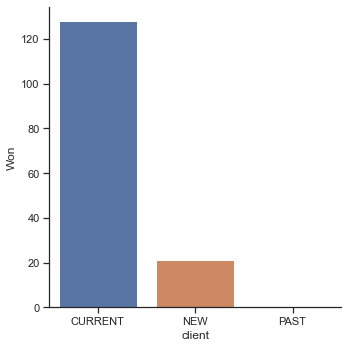

In [103]:
sns.catplot(x="client", y="Won", kind="bar", data=data);

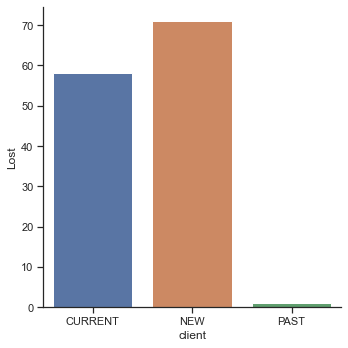

In [104]:
sns.catplot(x="client", y="Lost", kind="bar", data=data);